# Read CSV

In [1]:
import pandas as pd
import numpy as np

# Italian league

In [2]:
#data = pd.read_csv("SerieA-B/Serie_A-B_stats.csv")

# Dutch league

In [3]:
import os
data_folder = "Eredivisie"
data_frames = []
for data_file in os.listdir(data_folder):
    if data_file[-4:] == ".csv":
        data_frames.append(pd.read_csv(os.path.join(data_folder,data_file)))
        
data = pd.concat(data_frames)

In [4]:
data.head(1)

,AwayTeam,B365A,B365D,B365H,BSA,BSD,BSH,BWA,BWD,BWH,...,SJH,Unnamed: 58,Unnamed: 59,Unnamed: 60,VCA,VCD,VCH,WHA,WHD,WHH
0,Feyenoord,2.1,3.4,3.4,1.91,3.5,3.75,1.91,3.5,3.4,...,3.4,NaN,NaN,NaN,1.95,3.5,3.75,1.83,3.5,3.75


In [5]:
data.columns.values

array(['AwayTeam', 'B365A', 'B365D', 'B365H', 'BSA', 'BSD', 'BSH', 'BWA',
       'BWD', 'BWH', 'Bb1X2', 'BbAH', 'BbAHh', 'BbAv<2.5', 'BbAv>2.5',
       'BbAvA', 'BbAvAHA', 'BbAvAHH', 'BbAvD', 'BbAvH', 'BbMx<2.5',
       'BbMx>2.5', 'BbMxA', 'BbMxAHA', 'BbMxAHH', 'BbMxD', 'BbMxH', 'BbOU',
       'Date', 'Div', 'FTAG', 'FTHG', 'FTR', 'GBA', 'GBD', 'GBH', 'HTAG',
       'HTHG', 'HTR', 'HomeTeam', 'IWA', 'IWD', 'IWH', 'LBA', 'LBD', 'LBH',
       'PSA', 'PSCA', 'PSCD', 'PSCH', 'PSD', 'PSH', 'SBA', 'SBD', 'SBH',
       'SJA', 'SJD', 'SJH', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60',
       'VCA', 'VCD', 'VCH', 'WHA', 'WHD', 'WHH'], dtype=object)

# Set Index

In [6]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%y')
all_data = data.set_index('Date')

# Select features

In [7]:
data = all_data[['HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG']] 
data.head(5)

,HomeTeam,AwayTeam,FTR,FTHG,FTAG
Date,,,,,
2011-08-05,Excelsior,Feyenoord,A,0.0,2.0
2011-08-06,Heerenveen,Nijmegen,D,2.0,2.0
2011-08-06,Roda,Groningen,H,2.0,1.0
2011-08-06,VVV Venlo,Utrecht,D,0.0,0.0
2011-08-06,Waalwijk,Heracles,D,2.0,2.0


In [8]:
data.tail(5)

,HomeTeam,AwayTeam,FTR,FTHG,FTAG
Date,,,,,
2016-10-01,Vitesse,Groningen,H,2.0,1.0
2016-10-02,Ajax,Utrecht,H,3.0,2.0
2016-10-02,Heracles,Twente,D,1.0,1.0
2016-10-02,Sparta Rotterdam,AZ Alkmaar,D,1.0,1.0
2016-10-02,Willem II,Feyenoord,A,0.0,2.0


In [9]:
input_features = data

In [10]:
g = input_features.columns.to_series().groupby(data.dtypes).groups

In [11]:
object_features = {key.name: value for key, value in g.items()}['object']

In [12]:
object_features

['HomeTeam', 'AwayTeam', 'FTR']

# Create performance history per team

1. Track winning or losing streak as feature
2. Track total wins, losses and draws

In [13]:
class Stats:
    def __init__(self):
        self.win_streak = 0
        self.lose_streak = 0
        self.total_wins = 0
        self.total_losses = 0
        self.total_draws = 0
        self.total_games = 0
        self.previous_encounters = {}
        self.result_series = []
        
    def get_win_ratio(self):
        try:
            return (float(self.total_wins) / float(self.total_games))
        except:
            return(0)
        
    def get_win_ratio_against_opponent(self, opponent):
        try:
            results = self.previous_encounters[opponent]
            return sum(results)
        except:
            return(0)
        
    def games_played_in_period(self, today, period):
        games_played = 0
        for match in reversed(self.result_series):
            days_ago = (today - match["date"]).days
            if days_ago > period:
                return games_played
            else:
                games_played = games_played + 1
        return games_played
        
    def average_goals_scored_and_conceded(self, number_of_games):
        if self.total_games == 0:
            return (0,0)
        elif number_of_games > self.total_games:
            number_of_games = self.total_games
        games = self.result_series[-number_of_games:]
        goals_scored = 0
        goals_conceded = 0
        for game in games:
            goals_scored = goals_scored + game["goals_scored"]
            goals_conceded = goals_conceded + game["goals_conceded"]
            
        return (goals_scored/number_of_games, goals_conceded/number_of_games)
    
    def days_since_last_match(self,today):
        if len(self.result_series) == 0:
            return 365
        last_match_date = self.result_series[-1]["date"]
        return((today-last_match_date).days)
            
    #Results: 1 = win, 0 = draw, -1 = loss for this team against the opponent
    def update_previous_encounters(self, opponent, result):
        if opponent in self.previous_encounters:
            self.previous_encounters[opponent].append(result)
        else:
            self.previous_encounters[opponent] = [result]

    def update_result(self, opponent, goals_scored, goals_conceded, date):
        if pd.isnull(goals_scored) or pd.isnull(goals_conceded):
            return False
        result = 2
        if(goals_scored > goals_conceded):
            result = 1
            self.update_win()
        elif(goals_scored < goals_conceded):
            result = -1
            self.update_loss()
        else:
            result = 0
            self.update_draw()
        self.result_series.append({"result":result, "goals_scored":goals_scored, "goals_conceded":goals_conceded, "date":date})
        self.update_previous_encounters(opponent, result)
    
    def update_win(self):
        self.win_streak = self.win_streak + 1
        self.lose_streak = 0
        self.total_wins = self.total_wins + 1
        self.total_games = self.total_games + 1
        
    def update_loss(self):
        self.lose_streak = self.lose_streak + 1
        self.win_streak = 0
        self.total_losses = self.total_losses + 1
        self.total_games = self.total_games + 1
    
    def update_draw(self):
        self.total_draws = self.total_draws + 1
        self.win_streak = 0
        self.lose_streak = 0
        self.total_games = self.total_games + 1

In [14]:
teams = input_features.HomeTeam.unique()
stats = {}
for team in teams:
    stats[team] = Stats()

## Create feature arrays as columns for data frame

In [15]:
feature_names = ["win_streak",
    "lose_streak",
    "total_wins",
    "total_losses",
    "total_draws",
    "win_ratio",
    "opponent_win_ratio",
    "total_games",
    "goals_scored",
    "goals_conceded",
    "days_since_last_match",
    "games_played_in_two_weeks"]

home_results = {}
away_results = {}

for feature in feature_names:
    home_results[feature] = []
    away_results[feature] = []

## Add aggregated stats from previous matches as features then update stats based on this match

In [16]:
def update_results(results, stats, opponent,date):
    results["win_streak"].append(stats.win_streak)
    results["lose_streak"].append(stats.lose_streak)
    results["total_wins"].append(stats.total_wins)
    results["total_losses"].append(stats.total_losses)
    results["total_draws"].append(stats.total_draws)
    results["win_ratio"].append(stats.get_win_ratio())
    results["opponent_win_ratio"].append(stats.get_win_ratio_against_opponent(opponent))
    results["total_games"].append(stats.total_games)
    goals_scored, goals_conceded = stats.average_goals_scored_and_conceded(10)
    if pd.isnull(goals_scored):
        print(stats.result_series[-3:])
    results["goals_scored"].append(goals_scored)
    results["goals_conceded"].append(goals_conceded)
    results["days_since_last_match"].append(stats.days_since_last_match(date))
    results["games_played_in_two_weeks"].append(stats.games_played_in_period(date, 14))

    return results
    

for date, match in input_features.iterrows():
    home_team = match.HomeTeam
    home_stats = stats[home_team]
    
    away_team = match.AwayTeam
    away_stats = stats[away_team]
    
    home_results = update_results(home_results, home_stats, away_team, date)

    away_results = update_results(away_results, away_stats, home_team, date)
    
    #Update stats based on results of this match
    match_result = match.FTR    
    home_goals = match.FTHG
    away_goals = match.FTAG
        
    """if home_team == "Ajax":
        #print("total wins: " + str(home_stats.total_wins))
        #print("total games: " + str(home_stats.total_games))
        #print("win ratio: " + str(home_stats.get_win_ratio_against_opponent(away_team)))
        print("today: " + str(date))
        print("days since last match " + str(home_stats.days_since_last_match(date)))
    elif away_team == "Ajax":
        #print("total wins: " + str(away_stats.total_wins))
        #print("total games: " + str(away_stats.total_games))
        #print("win ratio: " + str(away_stats.get_win_ratio_against_opponent(home_team)))
        print("today: " + str(date))
        print("days since last match " + str(away_stats.days_since_last_match(date)))"""
        
    home_stats.update_result(away_team,home_goals,away_goals, date)
    away_stats.update_result(home_team,away_goals,home_goals, date)

In [17]:
    """if home_team == "Juventus" and away_team == "Roma":
        print("CHECK")
    if home_team == "Roma" and away_team == "Juventus":
        print("CHECK")"""

'if home_team == "Juventus" and away_team == "Roma":\n    print("CHECK")\nif home_team == "Roma" and away_team == "Juventus":\n    print("CHECK")'

In [18]:
columns = {}

for column_name, column  in home_results.iteritems():
    columns["home_" + column_name] = column
 
for column_name, column  in away_results.iteritems():
    columns["away_" + column_name] = column

In [19]:
input_features = pd.DataFrame(data=columns, index=data.index.values)

In [20]:
#input_features = input_features.drop(["away_total_losses", "home_total_losses", "away_total_wins", "home_total_wins", "away_total_draws", "home_total_draws"], 1)
#input_features = input_features[['home_win_streak', 'away_win_streak', 'home_lose_streak', 'away_lose_streak', 'home_win_ratio', 'away_win_ratio', 'home_days_since_last_match', 'away_days_since_last_match', 'home_opponent_win_ratio', 'away_opponent_win_ratio', 'home_games_played_in_two_weeks', 'away_games_played_in_two_weeks']]

In [21]:
input_features.head(10)

,away_days_since_last_match,away_games_played_in_two_weeks,away_goals_conceded,away_goals_scored,away_lose_streak,away_opponent_win_ratio,away_total_draws,away_total_games,away_total_losses,away_total_wins,...,home_goals_conceded,home_goals_scored,home_lose_streak,home_opponent_win_ratio,home_total_draws,home_total_games,home_total_losses,home_total_wins,home_win_ratio,home_win_streak
2011-08-05,365,0,0.0,0.0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0.0,0
2011-08-06,365,0,0.0,0.0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0.0,0
2011-08-06,365,0,0.0,0.0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0.0,0
2011-08-06,365,0,0.0,0.0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0.0,0
2011-08-06,365,0,0.0,0.0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0.0,0
2011-08-07,365,0,0.0,0.0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0.0,0
2011-08-07,365,0,0.0,0.0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0.0,0
2011-08-07,365,0,0.0,0.0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0.0,0
2011-08-07,365,0,0.0,0.0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0.0,0
2011-08-13,7,1,1.0,2.0,0,0,0,1,0,1,...,0.0,2.0,0,0,0,1,0,1,1.0,1


# Remove first half of a season so all stats have something to work with

In [22]:
#Season has 18 teams
#Each team plays 36 matches
#after 36 games each team should have played two games
buffer_games = 36
input_features = input_features[buffer_games:]

In [23]:
input_features.tail(5)

,away_days_since_last_match,away_games_played_in_two_weeks,away_goals_conceded,away_goals_scored,away_lose_streak,away_opponent_win_ratio,away_total_draws,away_total_games,away_total_losses,away_total_wins,...,home_goals_conceded,home_goals_scored,home_lose_streak,home_opponent_win_ratio,home_total_draws,home_total_games,home_total_losses,home_total_wins,home_win_ratio,home_win_streak
2016-10-01,7,1,1.5,1.4,0,-4,47,177,68,62,...,1.400000,1.300000,1,4,46,177,51,80,0.451977,0
2016-10-02,7,1,1.9,1.3,0,1,43,177,66,68,...,0.700000,2.400000,0,-1,44,177,17,116,0.655367,4
2016-10-02,7,1,1.9,1.9,0,4,49,177,48,80,...,1.400000,1.000000,0,-4,41,177,80,56,0.316384,0
2016-10-02,8,2,0.9,2.1,0,0,37,177,57,83,...,1.285714,1.285714,1,0,1,7,3,3,0.428571,0
2016-10-02,7,2,0.4,2.5,0,3,34,177,38,105,...,1.500000,0.900000,0,-3,29,109,55,25,0.229358,0


# Check for unusable fields

In [24]:
column_names = list(input_features.columns.values)

## Infinite values

In [25]:
for column in column_names:
    total_infinite_values = sum(np.isinf(input_features[column]))
    print (column + ": " + str(total_infinite_values))

away_days_since_last_match: 0
away_games_played_in_two_weeks: 0
away_goals_conceded: 0
away_goals_scored: 0
away_lose_streak: 0
away_opponent_win_ratio: 0
away_total_draws: 0
away_total_games: 0
away_total_losses: 0
away_total_wins: 0
away_win_ratio: 0
away_win_streak: 0
home_days_since_last_match: 0
home_games_played_in_two_weeks: 0
home_goals_conceded: 0
home_goals_scored: 0
home_lose_streak: 0
home_opponent_win_ratio: 0
home_total_draws: 0
home_total_games: 0
home_total_losses: 0
home_total_wins: 0
home_win_ratio: 0
home_win_streak: 0


In [26]:
for column in column_names:
    total_NaN_values = sum(np.isnan(input_features[column]))
    print (column + ": " + str(total_NaN_values))

away_days_since_last_match: 0
away_games_played_in_two_weeks: 0
away_goals_conceded: 0
away_goals_scored: 0
away_lose_streak: 0
away_opponent_win_ratio: 0
away_total_draws: 0
away_total_games: 0
away_total_losses: 0
away_total_wins: 0
away_win_ratio: 0
away_win_streak: 0
home_days_since_last_match: 0
home_games_played_in_two_weeks: 0
home_goals_conceded: 0
home_goals_scored: 0
home_lose_streak: 0
home_opponent_win_ratio: 0
home_total_draws: 0
home_total_games: 0
home_total_losses: 0
home_total_wins: 0
home_win_ratio: 0
home_win_streak: 0


#### Full time result as output
### First convert output to numeric for easyer processing

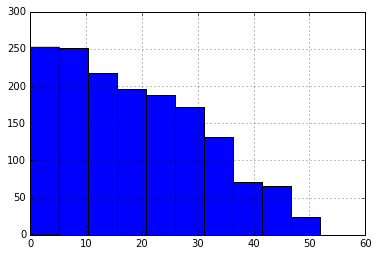

In [31]:
%matplotlib inline

input_features.away_total_draws.hist()

In [32]:
def ResultToNumeric(results):
    numericResults = []
    for result in results:
        if result == 'H':
            numericResults.append(0)
        elif result == 'A':
            numericResults.append(1)
        else:
            numericResults.append(2)
    return np.array(numericResults)

output = ResultToNumeric(data['FTR'])
output = output[buffer_games:]

# Baseline model

In [33]:
bins = np.bincount(output)
index = np.nonzero(bins)[0]
np.vstack((index,bins[index])).T

array([[  0, 721],
       [  1, 464],
       [  2, 384]], dtype=int64)

## Predict all games as a home win will result in 721/1569=0.460

# Try random forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=300,
                                                   max_features=7,
                                                   max_depth=None,
                                                   min_samples_split=10,
                                                   n_jobs=-1)

## Scoring

In [44]:
def report_scoring(scores):
    print("List of scores: " + str(scores))
    print("mean scoring: " + str(scores.mean()))
    print("Standard deviation between scorings: " + str(scores.std()))

In [45]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(random_forest_model, input_features, output)

report_scoring(scores)

List of scores: [ 0.5         0.46462715  0.39655172]
mean scoring: 0.45372629173
Standard deviation between scorings: 0.0429302379462


## Feature importance

In [32]:
trained_random_forest_model = random_forest_model.fit(input_features,output)
pd.Series(trained_random_forest_model.feature_importances_, input_features.columns)

away_days_since_last_match        0.034171
away_games_played_in_two_weeks    0.015635
away_goals_conceded               0.054915
away_goals_scored                 0.051632
away_lose_streak                  0.016306
away_opponent_win_ratio           0.028847
away_total_draws                  0.045657
away_total_games                  0.053459
away_total_losses                 0.049818
away_total_wins                   0.056336
away_win_ratio                    0.075950
away_win_streak                   0.020923
home_days_since_last_match        0.034748
home_games_played_in_two_weeks    0.015756
home_goals_conceded               0.051910
home_goals_scored                 0.053271
home_lose_streak                  0.022074
home_opponent_win_ratio           0.029178
home_total_draws                  0.045498
home_total_games                  0.048948
home_total_losses                 0.048557
home_total_wins                   0.051073
home_win_ratio                    0.077969
home_win_st

# Boosted random forest

In [33]:
from sklearn.ensemble import AdaBoostClassifier

boosted_random_forest_model = AdaBoostClassifier(n_estimators=1000)

## Scoring

In [34]:
scores = cross_val_score(boosted_random_forest_model, input_features, output)

report_scoring(scores)

List of scores: [ 0.3740458   0.41491396  0.33908046]
mean scoring: 0.376013406411
Standard deviation between scorings: 0.0309901431933


## Feature importance

In [35]:
trained_boosted_random_forest_model = boosted_random_forest_model.fit(input_features,output)
pd.Series(trained_boosted_random_forest_model.feature_importances_, input_features.columns)

away_days_since_last_match        0.021
away_games_played_in_two_weeks    0.000
away_goals_conceded               0.033
away_goals_scored                 0.041
away_lose_streak                  0.006
away_opponent_win_ratio           0.011
away_total_draws                  0.055
away_total_games                  0.096
away_total_losses                 0.063
away_total_wins                   0.056
away_win_ratio                    0.108
away_win_streak                   0.009
home_days_since_last_match        0.020
home_games_played_in_two_weeks    0.005
home_goals_conceded               0.048
home_goals_scored                 0.048
home_lose_streak                  0.005
home_opponent_win_ratio           0.009
home_total_draws                  0.041
home_total_games                  0.069
home_total_losses                 0.052
home_total_wins                   0.073
home_win_ratio                    0.116
home_win_streak                   0.015
dtype: float64

# SVM

In [36]:
from sklearn import svm

svm_model = svm.SVC()

## Scoring

In [37]:
scores = cross_val_score(svm_model, input_features, output)

report_scoring(scores)

List of scores: [ 0.45419847  0.45889101  0.45977011]
mean scoring: 0.457619867203
Standard deviation between scorings: 0.00244576602283


# TPOT

In [38]:
from tpot import TPOTClassifier

X_test = input_features.tail(612)
y_test = output[-612]

X_train = input_features[:612]
y_train = output[:612]

tpot = TPOTClassifier(generations=10, population_size=612, verbosity=3, scoring='accuracy')
tpot.fit(X_train, y_train)
#print(tpot.score(X_test, y_test))
tpot.export('tpot_soccer_pipeline.py')

Generation 1 - Current Pareto front scores:


1	0.519535675218	LinearSVC(input_matrix, 46.0, 47, False)


2	0.526135937975	LogisticRegression(Nystroem(input_matrix, 50, 7.0, 11), 37.0, 13, False)


Generation 2 - Current Pareto front scores:


1	0.519535675218	LinearSVC(input_matrix, 46.0, 47, False)


2	0.526135937975	LogisticRegression(Nystroem(input_matrix, 50, 7.0, 11), 37.0, 13, False)


Generation 3 - Current Pareto front scores:


1	0.519567950533	LogisticRegression(input_matrix, 0.10000000000000001, 0, True)


2	0.526135937975	LogisticRegression(Nystroem(input_matrix, 50, 7.0, 11), 37.0, 13, False)


3	0.527777895571	LinearSVC(PCA(Normalizer(input_matrix, 6), 8), 34.0, 1, False)


Generation 4 - Current Pareto front scores:


1	0.519567950533	LogisticRegression(input_matrix, 0.10000000000000001, 0, True)


2	0.529403911831	LinearSVC(Normalizer(input_matrix, 6), 34.0, 1, False)


Generation 5 - Current Pareto front scores:


1	0.531110184472	LinearSVC(input_matrix, 0.0001, 47, False)


Generation 6 - Current Pareto front scores:


1	0.531110184472	LinearSVC(input_matrix, 0.0001, 47, False)


3	0.53591594754	LinearSVC(LogisticRegression(Normalizer(input_matrix, 6), 28.0, 43, False), 34.0, 1, False)


Generation 7 - Current Pareto front scores:


1	0.531110184472	LinearSVC(input_matrix, 0.0001, 47, False)


3	0.53591594754	LinearSVC(LogisticRegression(Normalizer(input_matrix, 6), 28.0, 43, False), 34.0, 1, False)


Generation 8 - Current Pareto front scores:


1	0.531110184472	LinearSVC(input_matrix, 0.0001, 47, False)


2	0.539256285637	LinearSVC(RandomForestClassifier(input_matrix), 0.0001, 1, False)


3	0.539280354699	LinearSVC(DecisionTreeClassifier(LogisticRegression(input_matrix, 0.95000000000000007, 25, False)), 0.0001, 47, False)


Generation 9 - Current Pareto front scores:


1	0.531110184472	LinearSVC(input_matrix, 0.0001, 47, False)


2	0.539256285637	LinearSVC(RandomForestClassifier(input_matrix), 0.0001, 1, False)


3	0.539280354699	LinearSVC(DecisionTreeClassifier(LogisticRegression(input_matrix, 0.95000000000000007, 25, False)), 0.0001, 47, False)


Generation 10 - Current Pareto front scores:


1	0.531110184472	LinearSVC(input_matrix, 0.0001, 47, False)


2	0.539256285637	LinearSVC(RandomForestClassifier(input_matrix), 0.0001, 1, False)


3	0.539280354699	LinearSVC(DecisionTreeClassifier(LogisticRegression(input_matrix, 0.95000000000000007, 25, False)), 0.0001, 47, False)


# TPOT results in Gaussian Naive Bayes

In [39]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, Normalizer

exported_pipeline = make_pipeline(
    make_union(
        make_union(
            FunctionTransformer(lambda X: X),
            FunctionTransformer(lambda X: X)
        ),
        Normalizer(norm="l1")
    ),
    GaussianNB()
)

exported_pipeline.fit(X_train, y_train)

scores = cross_val_score(exported_pipeline, input_features, output)

report_scoring(scores)

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


List of scores: [ 0.41221374  0.46462715  0.50766284]
mean scoring: 0.461501242253
Standard deviation between scorings: 0.0390295691621
